<a href="https://colab.research.google.com/github/markobrnovic/ML2024/blob/main/ML_Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2.**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from IPython import display

In [2]:
# Uncomment to download the data

# !wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/x_L30.txt
# !wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/y_L30.txt
# !wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/T_L30.txt

x_L30 = np.loadtxt("x_L30.txt")
y_L30 = np.loadtxt("y_L30.txt", dtype = int)
T_L30 = np.loadtxt("T_L30.txt")

**a)**

In [3]:
# Shuffle the data (use the same seed for reproducibility)
np.random.seed(7)
indices = np.arange(len(x_L30))
np.random.shuffle(indices)
x_L30 = x_L30[indices]
y_L30 = y_L30[indices]
T_L30 = T_L30[indices]

# Data splitting
train_size = int(0.7 * len(x_L30))
val_size = int(0.2 * len(x_L30))
test_size = len(x_L30) - train_size - val_size

x_train, x_val, x_test = (
    x_L30[:train_size],
    x_L30[train_size:train_size + val_size],
    x_L30[train_size + val_size:]
)

y_train, y_val, y_test = (
    y_L30[:train_size],
    y_L30[train_size:train_size + val_size],
    y_L30[train_size + val_size:]
)

T_train, T_val, T_test = (
    T_L30[:train_size],
    T_L30[train_size:train_size + val_size],
    T_L30[train_size + val_size:]
)

In [4]:
#Defining the feed-forward neural network

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.relu    = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        a1 = self.sigmoid(linear1_out)

        #Layer 2:
        linear2_out = self.linear2(a1)
        a2 = self.softmax(linear2_out)

        #Network output:
        aL = a2

        return aL

In [5]:
# Specifying global settings for training

input_size  = x_train.shape[1]
output_size = 2

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)
x_val = torch.tensor(x_val, dtype = torch.float)

### One hot encoding ###
y_train_onehot = np.zeros((y_train.size, output_size))
y_train_onehot[np.arange(y_train.size), y_train] = 1
y_train_onehot = torch.tensor(y_train_onehot, dtype=torch.float)

y_val_onehot = np.zeros((y_val.size, output_size))
y_val_onehot[np.arange(y_val.size), y_val] = 1
y_val_onehot = torch.tensor(y_val_onehot, dtype=torch.float)

### Cost function: ###
cost_func = torch.nn.CrossEntropyLoss()

N_epochs = 1000 # number of times to run gradient descent

In [6]:
# Function for updating the plot
def updatePlot(epoch_list, cost_training, acc_training, cost_val, acc_val):
    # Plot the training cost
    plt.subplot(221)
    plt.plot(epoch_list, cost_training, 'o-', label='Training')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Training Cost')
    plt.legend()

    # Plot the training accuracy
    plt.subplot(223)
    plt.plot(epoch_list, acc_training, 'o-', label='Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    # Plot the validation cost
    plt.subplot(222)
    plt.plot(epoch_list, cost_val, 'o-', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Validation Cost')
    plt.legend()

    # Plot the validation accuracy
    plt.subplot(224)
    plt.plot(epoch_list, acc_val, 'o-', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()

In [7]:
def training(optimiser, learning_rate, hidden_size, wd, mom):

  model = FeedforwardNN(input_size, hidden_size, output_size)
  if optimiser == torch.optim.SGD:
    optimizer = optimiser(model.parameters(), lr=learning_rate, weight_decay = wd, momentum = mom)
  if optimiser == torch.optim.Adam:
    optimizer = optimiser(model.parameters(), lr=learning_rate, weight_decay = wd)
  ### Train for several epochs: ###

  epoch_list    = []
  cost_training = []
  cost_val = []
  acc_training  = []
  acc_val  = []

  # Train for several epochs
  for epoch in range(N_epochs):

    # Evaluation on training data
    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    train_output = model(x_train) # Neural network output
    train_cost = cost_func(train_output, y_train_onehot)
    train_cost.backward() #computes the gradients
    optimizer.step() #updating the parameters

    # Update the plot every 50 epochs
    if epoch % 50 == 0:

        val_output = model(x_val)
        val_cost = cost_func(val_output, y_val_onehot)

        train_predicted_class = np.argmax(train_output.detach().numpy(), axis=1)
        val_predicted_class = np.argmax(val_output.detach().numpy(), axis=1)
        train_accuracy = np.mean(train_predicted_class == y_train)
        val_accuracy = np.mean(val_predicted_class == y_val)

        epoch_list.append(epoch)
        cost_training.append(train_cost.detach().numpy())
        cost_val.append(val_cost.detach().numpy())
        acc_training.append(train_accuracy)
        acc_val.append(val_accuracy)

        plt.clf()  # Clear the current figure
        updatePlot(epoch_list, cost_training, acc_training, cost_val, acc_val)  # Update the plot
        plt.tight_layout()
        display.display(plt.gcf())
        print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n Validating cost %f\n  Validating accuracy %f\n" % (epoch, train_cost, train_accuracy, val_cost, val_accuracy))
        display.clear_output(wait=True)

  print("Final Training cost %f\nFinal Training accuracy %f\nFinal Validation cost %f\nFinal Validation accuracy %f\n" % (train_cost, train_accuracy, val_cost, val_accuracy) )

Final Training cost 0.320685
Final Training accuracy 0.994714
Final Validation cost 0.330242
Final Validation accuracy 0.985500



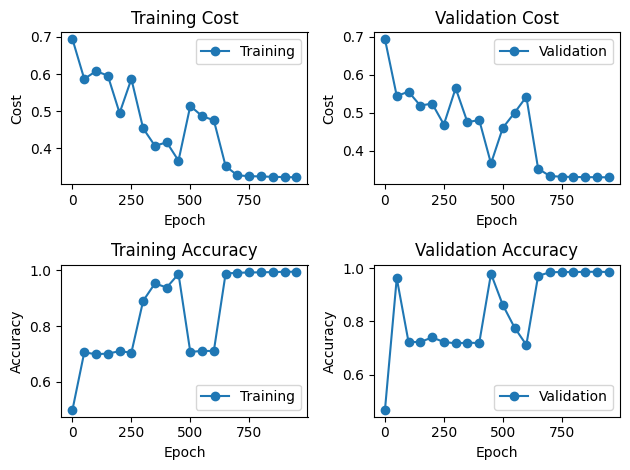

In [8]:
training(torch.optim.SGD, 1, 100, 0, 0)

The validation accuracy after a few hundred epochs starts decreasing which is a symptom of overfitting. However, it seems like the model then learns suddenly and accuracy goes up again. We sometimes get large dips in both accuracies, most likely attributable to stochasticity of the optimisation, and the learning rate might be too large.

**b)**

Final Training cost 0.328474
Final Training accuracy 0.991429
Final Validation cost 0.336167
Final Validation accuracy 0.985500



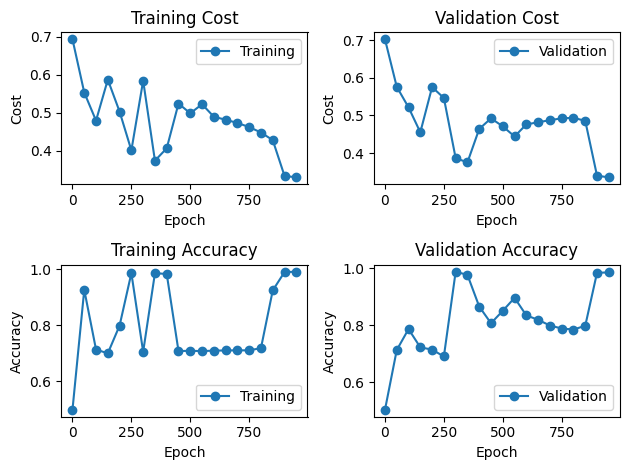

In [9]:
#just changing the optimiser to weight decaying one is equivalent to adding L2 regularisation (First Trial)
training(torch.optim.SGD, 1, 100, 0.001, 0)

The final accuracies are better, but stochasticity makes it hard to conclude that adding regularisation improved anything. Perhaps things will become clearer when we vary the learning rate.

Final Training cost 0.519240
Final Training accuracy 0.921000
Final Validation cost 0.515642
Final Validation accuracy 0.713500



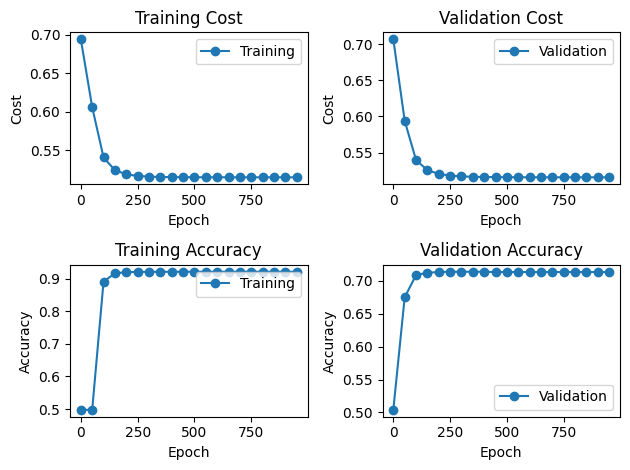

In [10]:
#just changing the optimiser to weight decaying one is equivalent to adding L2 regularisation (Second Trial)
training(torch.optim.SGD, 1, 100, 0.01, 0)

Here the regularisation parameter is too large, since the accuracy plateaus before the maximum values before. This is probably also an artifact of the learning rate.

Final Training cost 0.705961
Final Training accuracy 0.502429
Final Validation cost 0.706027
Final Validation accuracy 0.496000



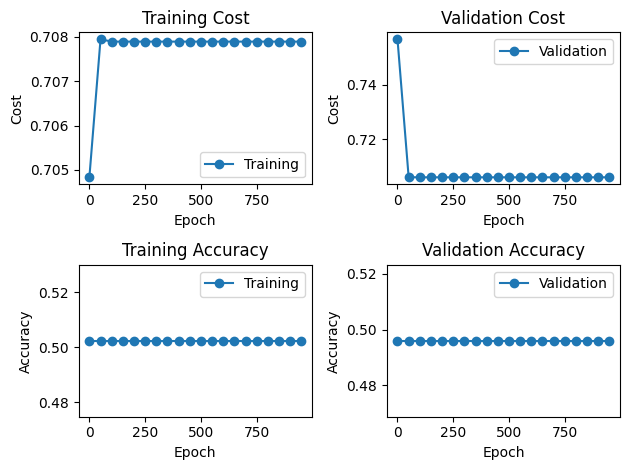

In [11]:
#just changing the optimiser to weight decaying one is equivalent to adding L2 regularisation (Third Trial)
training(torch.optim.SGD, 1, 100, 0.1, 0)

This network is not learning, meaning we went overboard with the regularisation. Moving on we will use weight_decay = 0.001.

**c)** Changing the learning rate

Final Training cost 0.407846
Final Training accuracy 0.985714
Final Validation cost 0.416764
Final Validation accuracy 0.981500



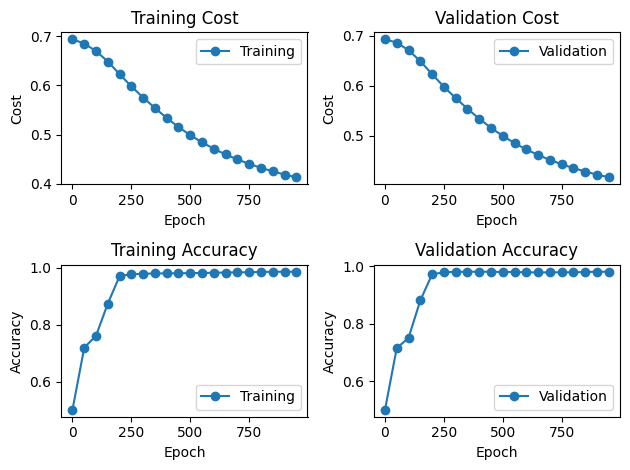

In [12]:
training(torch.optim.SGD, 0.1, 100, 0.001, 0)

Clearly this is better than before since stochasticity is decreased, and the model converges faster. Just to be sure, let us decrease it a magnitude further:

Final Training cost 0.659483
Final Training accuracy 0.766857
Final Validation cost 0.663706
Final Validation accuracy 0.757500



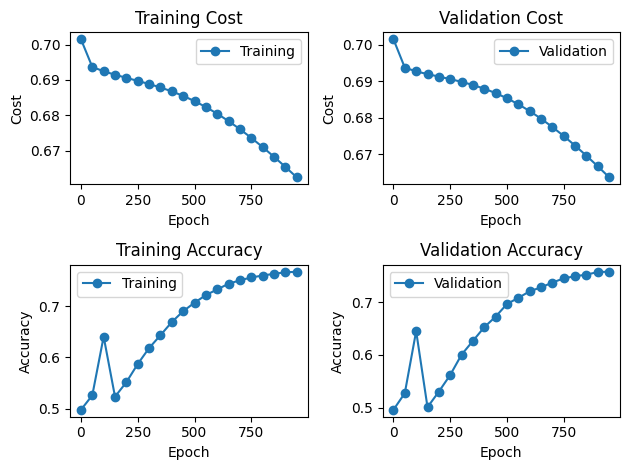

In [13]:
training(torch.optim.SGD, 0.01, 100, 0.001, 0)

It is converging, but much slower than before! We will therefore use lr = 0.1 for SGD.

**Different optimisers**

Final Training cost 0.363167
Final Training accuracy 0.990429
Final Validation cost 0.372189
Final Validation accuracy 0.984000



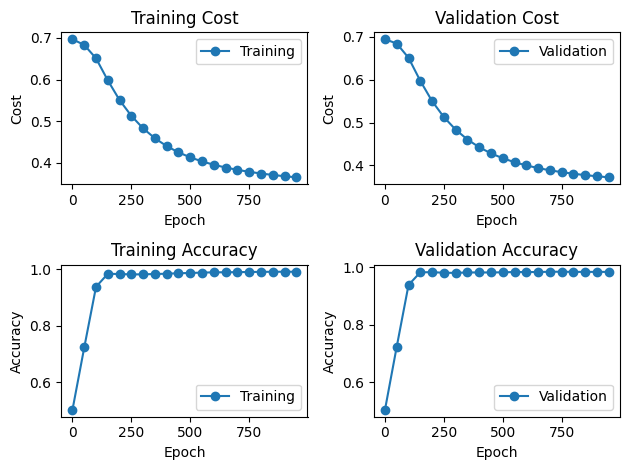

In [14]:
#SGD with momentum
training(torch.optim.SGD, 0.1, 100, 0.001, 0.5)

Good stuff. Now Adam:

Final Training cost 0.364888
Final Training accuracy 0.995429
Final Validation cost 0.391628
Final Validation accuracy 0.978500



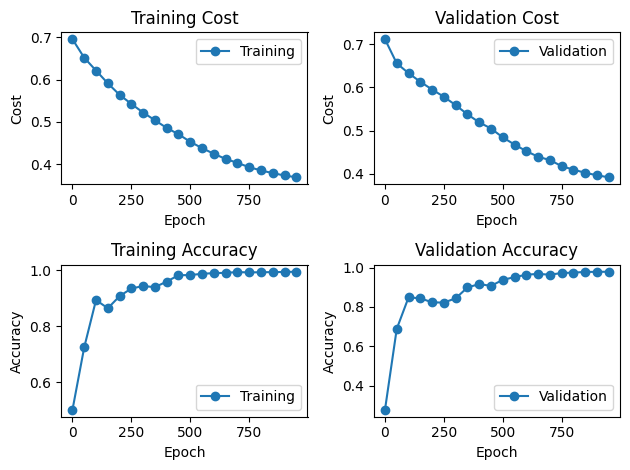

In [15]:
#Adam (I decreased the learning rate since I tried a few possibilities)
training(torch.optim.Adam, 0.001, 100, 0.001, 0)

Seems like I get the best results with Adam, will use it going forwards.

Final Training cost 0.342645
Final Training accuracy 0.997286
Final Validation cost 0.365902
Final Validation accuracy 0.983000



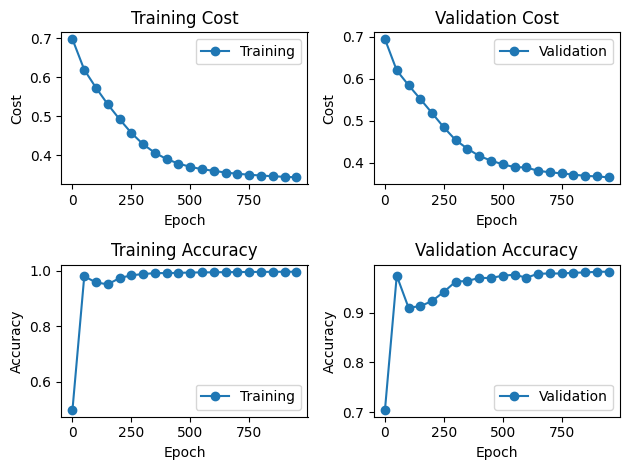

In [16]:
#Less hidden neurons
training(torch.optim.Adam, 0.001, 50, 0.001, 0)

Final Training cost 0.337075
Final Training accuracy 0.996714
Final Validation cost 0.348470
Final Validation accuracy 0.984000



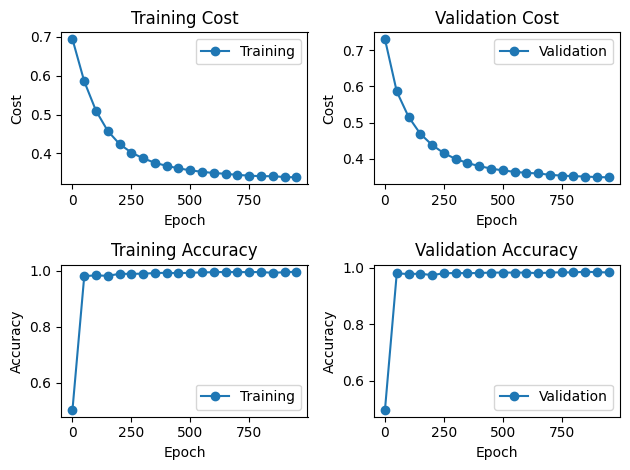

In [17]:
#More hidden neurons
training(torch.optim.Adam, 0.001, 200, 0.001, 0)

It doesn't change much... I will keep using 100. My highest validation accuracy (98.6%) is with Adam with learning rate 0.001, 100 hidden neurons, weight_decay = 0.001.

**d)**

In [18]:
#Just getting the model at the end, no plotting
def training_model(optimiser, learning_rate, hidden_size, wd, mom):

  model = FeedforwardNN(input_size, hidden_size, output_size)
  if optimiser == torch.optim.SGD:
    optimizer = optimiser(model.parameters(), lr=learning_rate, weight_decay = wd, momentum = mom)
  if optimiser == torch.optim.Adam:
    optimizer = optimiser(model.parameters(), lr=learning_rate, weight_decay = wd)
  ### Train for several epochs: ###

  epoch_list    = []
  cost_training = []
  cost_val = []
  acc_training  = []
  acc_val  = []

  # Train for several epochs
  for epoch in range(N_epochs):

    # Evaluation on training data
    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    train_output = model(x_train) # Neural network output
    train_cost = cost_func(train_output, y_train_onehot)
    train_cost.backward() #computes the gradients
    optimizer.step() #updating the parameters

    # Update the plot every 50 epochs
    if epoch % 50 == 0:

        val_output = model(x_val)
        val_cost = cost_func(val_output, y_val_onehot)

        train_predicted_class = np.argmax(train_output.detach().numpy(), axis=1)
        val_predicted_class = np.argmax(val_output.detach().numpy(), axis=1)
        train_accuracy = np.mean(train_predicted_class == y_train)
        val_accuracy = np.mean(val_predicted_class == y_val)

        epoch_list.append(epoch)
        cost_training.append(train_cost.detach().numpy())
        cost_val.append(val_cost.detach().numpy())
        acc_training.append(train_accuracy)
        acc_val.append(val_accuracy)

  print("Final Training cost %f\nFinal Training accuracy %f\nFinal Validation cost %f\nFinal Validation accuracy %f\n" % (train_cost, train_accuracy, val_cost, val_accuracy) )
  return model

In [19]:
best_model = training_model(torch.optim.Adam, 0.001, 100, 0.001, 0)

Final Training cost 0.348281
Final Training accuracy 0.995857
Final Validation cost 0.366512
Final Validation accuracy 0.983000



In [20]:
### Store the input data as a PyTorch tensor ###
x_test = torch.tensor(x_test, dtype = torch.float)

### One hot encoding ###
y_test_onehot = np.zeros((y_test.size, output_size))
y_test_onehot[np.arange(y_test.size), y_test] = 1
y_test_onehot = torch.tensor(y_test_onehot, dtype=torch.float)

In [21]:
test_output = best_model(x_test)
test_cost = cost_func(test_output, y_test_onehot)
test_predicted_class = np.argmax(test_output.detach().numpy(), axis=1)
print('Test accuracy is', np.mean(test_predicted_class == y_test))

Test accuracy is 0.979


97.8%, nice. A bit lower than validation (98.5%)

In [22]:
#Easier to work with original data, since I know each 250 new entries correspond to a different temperature:

x_L30 = np.loadtxt("x_L30.txt")
y_L30 = np.loadtxt("y_L30.txt", dtype = int)
T_L30 = np.loadtxt("T_L30.txt")

In [23]:
accuracies_T = np.zeros(40)
average_m = np.zeros(40)

for i in range(40):
  x_data = x_L30[i*250 : (i + 1) * 250]
  y_data = y_L30[i*250 : (i + 1) * 250]

  x_data = torch.tensor(x_data, dtype = torch.float)
  y_data_onehot = np.zeros((y_data.size, output_size))
  y_data_onehot[np.arange(y_data.size), y_data] = 1
  y_data_onehot = torch.tensor(y_data_onehot, dtype=torch.float)

  data_output = best_model(x_data)
  data_cost = cost_func(data_output, y_data_onehot)
  data_predicted_class = np.argmax(data_output.detach().numpy(), axis=1)
  accuracies_T[i] = np.mean(data_predicted_class == y_data)
  average_m[i] = np.mean(data_predicted_class)

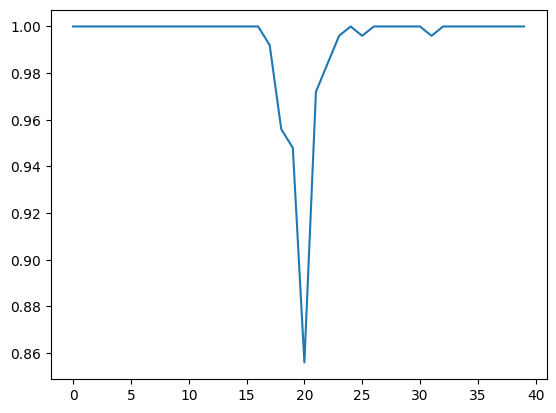

In [24]:
plt.plot(accuracies_T)

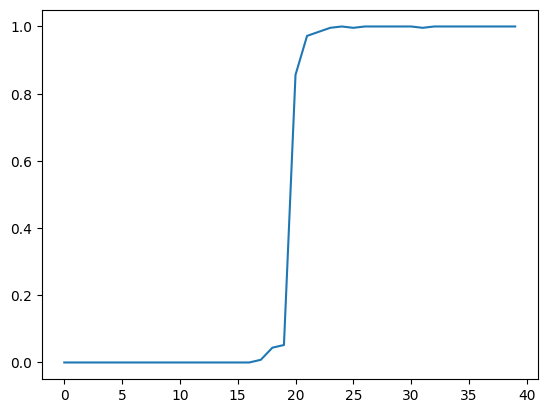

In [25]:
plt.plot(average_m)

The plots match the paper. As we approach the critical temperature, the model is worse at predicting the phase since we are close to the decision boundary between FM and PM phase. Away from that boundary, the model has very high accuracy. For the average magnetisation, it shows a discontinuity at the critical temperature which is a hallmark of a second order phase transition.